In [7]:
import pandas as pd
from pathlib import Path
import sys
sys.path.append('/Users/Ben/Home/Working/mu2e-tracker-factory/')
#print(sys.path)

## Make df of straws from file

In [8]:
# organized by their panel; includes batch, position number
#straw_list_file = Path("straws_on_panels.csv")
straw_list_file = Path("2022-04-07_straws_on_panels.csv")
straw_list_file = Path("2022-04-15_straws_on_panels.csv") #include paper pull grade
assert straw_list_file.is_file()
straws_df = pd.read_csv(straw_list_file, sep=",")
#straws_list = np.loadtxt(straw_list_file, delimiter=",", dtype=int, skiprows=1, usecols=range(1))
straws_df.columns = straws_df.columns.str.replace(" ", "")
straws_df = straws_df.rename(columns={"id": "straw"})
straws_df

,number,position_number,straw,batch,paper_pull_grade
0,173,0,20615,NaN,NaN
1,173,1,20759,120417B2,A
2,173,11,20474,NaN,NaN
3,173,12,20612,NaN,NaN
4,173,13,20756,120417B2,A
...,...,...,...,...,...
4424,237,91,28380,082814B3,A
4425,237,92,54253,NaN,NaN
4426,237,93,53112,NaN,NaN
4427,237,94,28410,082814B3,A


## Raw data location

In [9]:
from guis.common.getresources import GetProjectPaths
# straw leak raw data location
indir = GetProjectPaths()["strawleakdata"] / "raw_data"
print(indir)

/Users/Ben/Home/Working/mu2e-tracker-factory/data/StrawLeak/raw_data


## Straw Leak DF
### {straw, raw data file, fit value, fit error, fit status}
#### this step takes the longest (~minutes)

In [12]:
from calc_straw_leak import refit, NotEnoughData

In [13]:
# one row for each file – many rows for one straw are allowed.
file_list = []
for raw_data_file in indir.glob("*.txt"):
    straw = str(raw_data_file.name)[2:7]
    
    #if straw != "23839":
    #    continue
        
    try:
        straw = int(straw)
    except ValueError:
        print("BAD FILE (FILENAME)", raw_data_file.name)
        continue

    try:
        leak_rate, leak_rate_err, leak_status = refit(raw_data_file)
    except NotEnoughData:
        continue
    except IndexError as e:
        print("BAD FILE (INDEX)", e, raw_data_file.name)
    except ValueError as e:
        print("BAD FILE (VALUE)", raw_data_file.name)
        continue
        
    file_list.append(
        {
            'straw':straw,
            'leak_data_file':str(raw_data_file),
            'rate': leak_rate,
            'rate_err':leak_rate_err,
            'status':leak_status
        }
    )
file_df = pd.DataFrame(file_list)  
file_df

BAD FILE (VALUE) ST17028_chamber11_2021_06_25_rawdata.txt
BAD FILE (VALUE) ST24897_chamber20_2022_01_28_rawdata.txt
BAD FILE (VALUE) ST99005_chamber24_2021_06_25_rawdata.txt
BAD FILE (VALUE) ST99002_chamber9_2021_06_25_rawdata.txt
BAD FILE (FILENAME) ST4163_chamber15_2021_06_17_rawdata.txt


,straw,leak_data_file,rate,rate_err,status
0,28107,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000073,0.000010+0.000000j,PassFailStatus.PASS
1,81015,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000059,0.000006+0.000000j,PassFailStatus.PASS
2,23399,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000087,0.000005+0.000000j,PassFailStatus.PASS
3,9628,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000111,0.000010+0.000000j,PassFailStatus.UNKNOWN
4,28141,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000065,0.000010+0.000000j,PassFailStatus.UNKNOWN
...,...,...,...,...,...
14817,3128,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000633,0.000013+0.000000j,PassFailStatus.FAIL
14818,18612,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.001307,0.000017+0.000000j,PassFailStatus.FAIL
14819,23074,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000055,0.000006+0.000000j,PassFailStatus.PASS
14820,17482,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000500,0.000013+0.000000j,PassFailStatus.FAIL


## Clean data – remove negative rates, failed tests. Keep smallest rate.

In [14]:
# show straws with multiple tests
df = file_df.rename_axis(None)
df[df.straw.duplicated(keep=False)].sort_values(by=['straw'])

,straw,leak_data_file,rate,rate_err,status
4782,597,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,7.451430e-05,4.464692e-06+0.000000e+00j,PassFailStatus.PASS
1414,597,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,4.094147e-05,6.359583e-06+0.000000e+00j,PassFailStatus.PASS
1120,813,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,6.641748e-05,7.994249e-06+0.000000e+00j,PassFailStatus.PASS
1850,813,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,2.990365e-03,7.985771e-05+0.000000e+00j,PassFailStatus.FAIL
8379,828,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,2.789674e-03,9.564482e-05+0.000000e+00j,PassFailStatus.FAIL
...,...,...,...,...,...
7715,99010,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,-3.729291e-07,3.820644e-07+0.000000e+00j,PassFailStatus.PASS
13207,99010,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,-1.264805e-05,3.115735e-07+0.000000e+00j,PassFailStatus.PASS
5572,99010,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,1.114769e-05,1.356473e-07+0.000000e+00j,PassFailStatus.PASS
3655,99010,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,5.563697e-05,2.647257e-06+0.000000e+00j,PassFailStatus.PASS


In [15]:
# remove negative leak values
df.drop(df[ df['rate'] <= 0 ].index , inplace=True)

# remove failed, unknown tests
df.drop(df[ df['status'] == "PassFailStatus.FAIL"].index , inplace=True)
df.drop(df[ df['status'] == "PassFailStatus.UNKOWN"].index , inplace=True)

# only keep the tests with the smallest leaks
df = df.groupby('straw', group_keys=False).apply(lambda x: x.loc[x.rate.idxmin()])

In [16]:
df

,straw,leak_data_file,rate,rate_err,status
straw,,,,,
53,53,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,7.940945e-05,5.145568e-06+0.000000e+00j,PassFailStatus.PASS
61,61,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,1.644772e-03,5.351277e-05+0.000000e+00j,PassFailStatus.FAIL
62,62,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,5.631397e-05,3.918778e-06+0.000000e+00j,PassFailStatus.PASS
68,68,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,7.273100e-05,8.656017e-06+0.000000e+00j,PassFailStatus.PASS
266,266,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,2.331096e-05,5.851456e-06+0.000000e+00j,PassFailStatus.PASS
...,...,...,...,...,...
99006,99006,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,5.496361e-06,2.587760e-06+0.000000e+00j,PassFailStatus.PASS
99007,99007,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,3.917896e-07,4.729616e-07+0.000000e+00j,PassFailStatus.PASS
99008,99008,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,2.293081e-05,5.583669e-07+0.000000e+00j,PassFailStatus.PASS


In [17]:
# show that we've removed all but the smallest rates
df = df.rename_axis(None)
#df[df.straw.duplicated(keep=False)].sort_values(by=['straw']) # throwing error. maybe no duplicates.
df.sort_values(by=['straw'])

,straw,leak_data_file,rate,rate_err,status
53,53,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,7.940945e-05,5.145568e-06+0.000000e+00j,PassFailStatus.PASS
61,61,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,1.644772e-03,5.351277e-05+0.000000e+00j,PassFailStatus.FAIL
62,62,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,5.631397e-05,3.918778e-06+0.000000e+00j,PassFailStatus.PASS
68,68,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,7.273100e-05,8.656017e-06+0.000000e+00j,PassFailStatus.PASS
266,266,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,2.331096e-05,5.851456e-06+0.000000e+00j,PassFailStatus.PASS
...,...,...,...,...,...
99006,99006,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,5.496361e-06,2.587760e-06+0.000000e+00j,PassFailStatus.PASS
99007,99007,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,3.917896e-07,4.729616e-07+0.000000e+00j,PassFailStatus.PASS
99008,99008,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,2.293081e-05,5.583669e-07+0.000000e+00j,PassFailStatus.PASS
99009,99009,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,6.115498e-07,3.777829e-07+0.000000e+00j,PassFailStatus.PASS


In [ ]:
# about 3000 duplicates removed
df

In [18]:
import matplotlib.pyplot as plt
from numpy.testing import suppress_warnings
from numpy import ComplexWarning

## Merge the straws-by-panel df with the leak rate-by-straw df

In [19]:
final_df = straws_df.merge(df, on=['straw'], how = 'left')

In [20]:
df.to_csv("all_straw_info_MN173_MN235.csv")

In [21]:
final_df

,number,position_number,straw,batch,paper_pull_grade,leak_data_file,rate,rate_err,status
0,173,0,20615,NaN,NaN,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000072,0.000007+0.000000j,PassFailStatus.PASS
1,173,1,20759,120417B2,A,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000100,0.000007+0.000000j,PassFailStatus.FAIL
2,173,11,20474,NaN,NaN,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000053,0.000008+0.000000j,PassFailStatus.PASS
3,173,12,20612,NaN,NaN,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000072,0.000008+0.000000j,PassFailStatus.PASS
4,173,13,20756,120417B2,A,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000074,0.000008+0.000000j,PassFailStatus.PASS
...,...,...,...,...,...,...,...,...,...
4424,237,91,28380,082814B3,A,NaN,NaN,N00000000a00000000N,NaN
4425,237,92,54253,NaN,NaN,/Users/Ben/Home/Working/mu2e-tracker-factory/d...,0.000027,0.000007+0.000000j,PassFailStatus.PASS
4426,237,93,53112,NaN,NaN,NaN,NaN,N00000000a00000000N,NaN
4427,237,94,28410,082814B3,A,NaN,NaN,N00000000a00000000N,NaN


## for straws without leak rates, see if their daughter has a leak rate
### TODO

In [22]:
from numpy import nan

In [ ]:
# select straws without leak rates
final_df[final_df['rate'].isna()]

# drop straws without leak rates
test_df = final_df[final_df['rate'].notna()]

# get batch, leak info from parent, which = daughter_straw_no - 30000

## Sum leak rates by panel

In [ ]:
fig, ax = plt.subplots(1, 1)
final_df.groupby(['number'])['rate'].sum().plot(kind="bar", figsize=(15,8),ax=ax)
ax.set_ylabel("integrated straw leaks",fontsize=20)
ax.set_xlabel("panel",fontsize=20)
#ax.set_title("all panels",fontsize=25)
fig.savefig(f"summed_straw_leaks_by_panel_2.png")
plt.close(fig)

## Mean leak rates by panel

In [ ]:
fig, ax = plt.subplots(1, 1)
ax = final_df.groupby(['number'])['rate'].mean().plot(kind="bar", figsize=(15,8))
ax.set_ylabel("mean straw leak rate",fontsize=20)
ax.set_xlabel("panel",fontsize=20)
fig.savefig(f"mean_straw_leak_rate_per_panel_2.png")
plt.close()

## Median leak rates by panel

In [ ]:
fig, ax = plt.subplots(1, 1)
ax = final_df.groupby(['number'])['rate'].median().plot(kind="bar", figsize=(15,8))
ax.set_ylabel("median straw leak rate",fontsize=20)
ax.set_xlabel("panel",fontsize=20)
fig.savefig(f"median_straw_leak_rate_per_panel_2.png")
plt.close()

## all straw leaks across all panels
#### TODO make this a heat map/histogram

In [23]:
fig, ax = plt.subplots(1, 1)
final_df.plot.scatter(ax = ax, x='position_number',y='rate',ylim=(-2e-5,22e-5),figsize=(15,10))
ax.set_ylabel("individual straw leak rate",fontsize=25)
ax.set_xlabel("straw position on panel",fontsize=25)
ax.set_title("all panels",fontsize=25)
fig.savefig(f"all_straw_leaks_by_position.png")
plt.close(fig)

In [32]:
yvals=final_df['rate'].to_numpy()
xvals=final_df['position_number'].to_numpy()

ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.core.MaskedArray with masked values

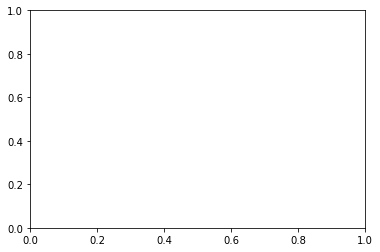

In [35]:
import numpy as np
fig, ax = plt.subplots(1, 1)
# Creating bins
x_min = np.min(xvals)
x_max = np.max(xvals)
  
y_min = np.min(yvals)
y_max = np.max(yvals)
  
x_bins = np.linspace(x_min, x_max, 50)
y_bins = np.linspace(y_min, y_max, 20)

ax.hist2d(xvals,yvals,bins=[x_bins, y_bins])
#ax.hist2d(final_df.position_number, final_df.rate, bins=100)
#final_df.plot.hist2d(ax = ax, x='position_number',y='rate') #,ylim=(-2e-5,22e-5),figsize=(15,10))
#axes[0, 0].hist2d(data[:, 0], data[:, 1], bins=100)

In [ ]:
#final_df[final_df['number']==192][['pos','rate']]

## straw leaks by panel vs straw position

In [ ]:
for panel in range(173,175):
    fig, ax = plt.subplots(1, 1)
    try:
        with suppress_warnings() as sup:
            sup.filter(ComplexWarning)
            # bar
            final_df[final_df['number']==panel][['position_number','rate','rate_err']].plot(
                x='position_number',y='rate',
                yerr='rate_err',
                kind="bar", 
                figsize=(20,10), ax = ax,ylim=(0,13e-5)
            )
            
            # scatter (eww)
            #final_df[final_df['number']==panel][['pos','rate','rate_err']].plot(
            #    x='pos',y='rate',
            #    yerr='rate_err',
            #    kind="scatter", 
            #    figsize=(20,10), ax = ax,ylim=(0,13e-5),s=60
            #)
    except TypeError:
        print("NO DATA",panel)
        plt.close(fig)
        continue
    except ValueError:
        print("problem?",panel)
        plt.close(fig)
        continue
    
    # calculate mean
    heights = final_df[final_df['number']==panel]['rate']
    freq = heights.value_counts().sort_index()
    freq_frame = freq.to_frame()
    mean = round(heights.mean(),8)
    median = heights.median()
    
    ax.set_ylabel("individual straw leak rate",fontsize=25)
    ax.set_xlabel("straw position on panel",fontsize=25)
    ax.set_title(f'MN{panel} (mean={mean})',fontsize=25)
    fig.savefig(f"MN{panel}_bar.png")
    plt.close(fig)

## Straw leaks by panel vs leak rate histogram

In [ ]:
for panel in range(173,175):
    fig, ax = plt.subplots(1, 1)
    try:
        with suppress_warnings() as sup:
            sup.filter(ComplexWarning)
            result = final_df[final_df.number == panel]['rate'].hist(figsize=(14,7),bins=12)
    except TypeError:
        print("NO DATA",panel)
        plt.close(fig)
        continue
    except ValueError:
        print("problem?",panel)
        plt.close(fig)
        continue

    # calculate mean
    heights = final_df[final_df['number']==panel]['rate']
    freq = heights.value_counts().sort_index()
    freq_frame = freq.to_frame()
    mean = round(heights.mean(),8)
    median = heights.median()

    # mean line
    plt.axvline(mean, color='k', linestyle='dashed', linewidth=1)
    #plt.axvline(median, color='k', linestyle='dashed', linewidth=1)
    ax.set_xlim((0,1e-4))
    ax.set_ylim((0,25))
    ax.set_ylabel("n straws",fontsize=25)
    ax.set_xlabel("leak rate (sccm)",fontsize=25)
    ax.set_title(f'MN{panel}',fontsize=25)
    fig.savefig(f"MN{panel}_leak_hist.png")
    plt.close(fig)

## Batch distribution per panel

#### convert batches into categories and clean

In [ ]:
from pandas.api.types import CategoricalDtype
batches = CategoricalDtype(categories=["oct","nov","dec","g-2","proto","na"], ordered=True)
codes = {'10':'oct', '11':'nov', '12':'dec', '08':"proto", 'g2':'g-2', "na":'unknown'}

In [ ]:
#final_df[final_df['number']==192][['position_number','rate']]
#final_df[final_df['number'] == 173]

In [ ]:
df2 = final_df.copy()
# df2

# list of all batch numbers
# print(df2.batch.astype('category').unique().tolist())

# clean up
df2['batch'] = df2['batch'].replace('\r\n', nan)
df2['batch'] = df2['batch'].replace('110917.B6\r\n', '110917B6')
df2['batch'] = df2['batch'].replace('110717.B5\r\n', '110717B5')
# print(df2.batch.astype('category').unique().tolist())

# convert g-2:
df2['batch'] = df2['batch'].replace('123456B1', 'g2')

# parse just the first two digits
df2['batch_parsed'] = df2['batch'].astype(str).str[:2].astype('category',Ordered=True)
print("all batches:\n",df2.batch_parsed.unique())

# map to a readable string
df2['batch_cats'] = df2['batch_parsed'].map(codes)
print(df2.batch_cats.unique())

#### Straw Batch All Panels

In [ ]:
fig, ax = plt.subplots(1, 1)

# distribution of batches across all panels
df2['batch_cats'].value_counts(sort=False).plot.bar(rot=0,figsize=(15,8))

ax.set_ylabel("n straws",fontsize=25)
ax.set_xlabel("Batch",fontsize=25)
ax.set_title(f'Straw Batch All Panels (MN170 - MN230)',fontsize=25)
fig.savefig(f"batch_composition_all_straws.png")

plt.close(fig)

#### Straw Batch Composition vs Panel

In [ ]:
fig, ax = plt.subplots(1, 1)

# distribution of batches vs panel
df2.groupby(['number', 'batch_cats'])['batch_cats'].count().unstack().plot.bar(
    stacked=True, 
    figsize=(15,8),
    ax=ax,
)

# identical batches vs panel plot
#pd.crosstab(index=df2['number'], columns=df2['batch_cats'], values=df2['number'], aggfunc='count').plot.bar(
#        stacked=True,
#        figsize=(15,8)
#    )
ax.set_ylim((0,130))
ax.set_ylabel("N Straws",fontsize=25)
ax.set_xlabel("Panel",fontsize=25)
ax.set_title(f'Batch Composition by Panel (MN170 - MN230)',fontsize=25)
fig.savefig(f"batch_composition_by_panel.png")

plt.close(fig)

## Paper pull composition by panel

In [ ]:
#grades = CategoricalDtype(categories=["A","B","C","nan"], ordered=True)
grade_codes = {'A':'A', 'B':'B', 'C':'C', 'nan':"unknown"}
df2['ppg'] = df2['paper_pull_grade'].astype(str).astype('category',Ordered=True)
df2['ppg'] = df2['ppg'].map(grade_codes)
print("all grades:\n",df2.ppg.unique())

#### ppg all panels

In [ ]:
# all grades all panels
fig, ax = plt.subplots(1, 1)

# distribution of batches across all panels
df2['ppg'].value_counts(sort=False).plot.bar(rot=0,figsize=(15,8))

ax.set_ylabel("n straws",fontsize=25)
ax.set_xlabel("Paper Grade",fontsize=25)
ax.set_title(f'Straw Paper Grade All Panels (MN170 - MN230)',fontsize=25)
fig.savefig(f"ppg_composition_all_straws.png")

plt.close(fig)

#### ppg composition vs panel

In [ ]:
fig, ax = plt.subplots(1, 1)

# distribution of batches vs panel
df2.groupby(['number', 'ppg'])['ppg'].count().unstack().plot.bar(
    stacked=True, 
    figsize=(15,8),
    ax=ax,
)

# identical batches vs panel plot
#pd.crosstab(index=df2['number'], columns=df2['batch_cats'], values=df2['number'], aggfunc='count').plot.bar(
#        stacked=True,
#        figsize=(15,8)
#    )
#ax.bar_label(ax.containers[0])
ax.set_ylim((0,130))
ax.set_ylabel("N Straws",fontsize=25)
ax.set_xlabel("Panel",fontsize=25)
ax.set_title(f'Paper Grade Composition by Panel (MN170 - MN230)',fontsize=25)
fig.savefig(f"ppg_composition_by_panel.png")

plt.close(fig)